
<font size="5">**<center> ĐỒ ÁN CUỐI KỲ </center>** </font>

<font size="4">**<center> kHOA HỌC DỮ LIỆU ỨNG DỤNG</center>** </font>

> Họ tên: Thái Bá Sơn

> MSSV: 1712732

# I/ Khai thác dữ liệu:

Dữ liệu khai thác từ: [đây](https://www.nasdaq.com/) 

Cấu trúc câu lệnh khai thác: 'https://www.nasdaq.com/market-activity/stocks/' + 'stock_code' + '/historical'


# I/ Dữ liệu

### Thông tin về dữ liệu:


Trong sổ tay này, chúng ta sẽ xem xét dữ liệu từ thị trường chứng khoán, đặc biệt là một số cổ phiếu công nghệ. Sử dụng pandas để lấy thông tin cổ phiếu, hình dung các khía cạnh khác nhau của nó và cuối cùng ta sẽ xem xét một số cách phân tích rủi ro của cổ phiếu, dựa trên lịch sử hoạt động trước đó của nó. Chúng tôi cũng sẽ dự đoán giá cổ phiếu trong tương lai thông qua phương pháp Long Short Term Memory (LSTM)! 

**Nguồn:** 

---

# II/ Khám phá dữ liệu:

### Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

### Đọc dữ liệu từ file csv vào dataframe

In [2]:
df = pd.read_csv("stock_data.csv", sep = '\t', index_col = 0)
df.head()

,Date,Close/Last,Volume,Open,High,Low,Company
0,12/15/2020,$1761.08,1068292,$1759.86,$1764,$1741.67,Alphabet
1,12/14/2020,$1752.26,1652471,$1770.72,$1789.8,$1749.13,Alphabet
2,12/11/2020,$1774.8,931431,$1760,$1777.31,$1752.74,Alphabet
3,12/10/2020,$1767.65,1434416,$1762.6,$1774.99,$1733.527,Alphabet
4,12/09/2020,$1777.86,1586426,$1810.36,$1828.37,$1762.0001,Alphabet


### Thông tin thuộc tính:

In [3]:
num_rows, num_cols = df.shape
print("Dữ liệu có {} dòng, {} cột.".format(num_rows, num_cols))

Dữ liệu có 7551 dòng, 7 cột.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7550
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         7551 non-null   object
 1    Close/Last  7551 non-null   object
 2    Volume      7551 non-null   int64 
 3    Open        7551 non-null   object
 4    High        7551 non-null   object
 5    Low         7551 non-null   object
 6   Company      7551 non-null   object
dtypes: int64(1), object(6)
memory usage: 471.9+ KB


In [5]:
df.info

<bound method DataFrame.info of             Date  Close/Last    Volume       Open       High          Low  \
0     12/15/2020    $1761.08   1068292   $1759.86      $1764     $1741.67   
1     12/14/2020    $1752.26   1652471   $1770.72    $1789.8     $1749.13   
2     12/11/2020     $1774.8    931431      $1760   $1777.31     $1752.74   
3     12/10/2020    $1767.65   1434416    $1762.6   $1774.99    $1733.527   
4     12/09/2020    $1777.86   1586426   $1810.36   $1828.37   $1762.0001   
...          ...         ...       ...        ...        ...          ...   
7546  12/22/2015      $55.35  28305310     $54.99     $55.48        $54.5   
7547  12/21/2015      $54.83  37221910     $54.88     $55.35     $54.2262   
7548  12/18/2015      $54.13  84141520     $55.77        $56       $54.03   
7549  12/17/2015       $55.7  41244620     $56.36     $56.79     $55.5348   
7550  12/16/2015      $56.13  37473420     $55.54    $56.245       $54.76   

        Company  
0      Alphabet  
1      

Thông tin thuộc tính:
- **Date**: Trường mà học sinh đang theo học (2 trường: 'GP' - Gabriel Pereira hoặc 'MS' - Mousinho da Silveira).
- **Close/Last**: giới tính của học sinh (nhị phân: 'F' - nữ hoặc 'M' - nam).
- **Volume**: tuổi của học sinh (số: từ 15 đến 22).
- **Open**: loại địa chỉ nhà của sinh viên (nhị phân: 'U' - thành thị hoặc 'R' - nông thôn).
- **High**: quy mô gia đình (nhị phân: 'LE3' - nhỏ hơn hoặc bằng 3 hoặc 'GT3' - lớn hơn 3).
- **Low**: tình trạng chung sống của cha mẹ (nhị phân: 'T' - sống chung hoặc 'A' - xa nhau).
- **Company**: giáo dục của mẹ (số: 0 - không, 1 - giáo dục tiểu học (lớp 4), 2 - lớp 5 đến lớp 9, 3 - giáo dục trung học hoặc 4 - giáo dục đại học).

---

## Tiền xử lý:

- Kiểm tra dữ thông tin dữ liệu: kiểu dữ liệu của các thuộc tính, các cột có bị thiếu giá trị hay không?...

In [6]:
#xem thông tin data:
df.info()

if df.isnull().values.any() == False:
    print("=> Không có ô giá trị nào bị thiếu.")
else:
    print("Dữ liệu bị thiếu.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7550
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         7551 non-null   object
 1    Close/Last  7551 non-null   object
 2    Volume      7551 non-null   int64 
 3    Open        7551 non-null   object
 4    High        7551 non-null   object
 5    Low         7551 non-null   object
 6   Company      7551 non-null   object
dtypes: int64(1), object(6)
memory usage: 471.9+ KB
=> Không có ô giá trị nào bị thiếu.


- Định dạng lại kiểu dữ liệu cho phù hợp.

In [22]:
df = pd.read_csv("stock_data.csv", sep = '\t', index_col = 0)

#Định dạng lại cột Date sang kiểu dữ liệu datetime
df["Date"] = pd.to_datetime(df["Date"])

#Đặt index là ngày:
df.set_index('Date', inplace = True)

#Xóa khoảng trắng trong dữ liệu:
df.columns = df.columns.str.replace(' ', '') 
df.replace(' ', '', regex=True, inplace = True)

#Chuyển cột có ký hiệu tiền tệ ($) sang dạng datetime:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

#Sắp xếp cổ phiếu tăng dần theo ngày:
df.sort_values(['Company', 'Date'], ascending=[True, True], inplace = True)

company_name = list(df["Company"].unique())

- Dữ liệu sau khi tiền xử lý:

In [23]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7551 entries, 2015-12-16 to 2020-12-15
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  7551 non-null   float64
 1   Volume      7551 non-null   int64  
 2   Open        7551 non-null   float64
 3   High        7551 non-null   float64
 4   Low         7551 non-null   float64
 5   Company     7551 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 412.9+ KB


,Close/Last,Volume,Open,High,Low,Company
Date,,,,,,
2015-12-16,776.59,2651259,766.57,781.50,757.045,Alphabet
2015-12-17,769.83,1823211,781.16,781.59,769.300,Alphabet
2015-12-18,756.85,3374853,767.23,774.14,756.590,Alphabet
2015-12-21,760.80,1737946,763.05,766.35,754.150,Alphabet
2015-12-22,767.13,1814253,764.27,770.34,761.200,Alphabet


In [24]:
# Summary Stats
df.describe()

,Close/Last,Volume,Open,High,Low
count,7551.000000,7.551000e+03,7551.000000,7551.000000,7551.000000
mean,509.083231,3.903217e+07,509.058726,514.427697,503.233695
std,666.505966,5.331818e+07,666.740528,674.020794,658.515123
min,22.585000,5.211410e+05,22.500000,22.917500,22.367500
25%,62.063750,3.977700e+06,62.147000,62.945000,61.068500
50%,150.480000,2.024858e+07,150.740000,152.430000,148.960000
75%,852.250000,4.401898e+07,851.760000,855.570000,847.512500
max,3531.450000,5.322360e+08,3547.000000,3552.250000,3486.685000


# III/ Đặt câu hỏi:
- 1. Liệu trình độ học vấn của cha mẹ có quyết định đến thành tích học tập của con ở trường hay không?

- 2. Có phải hầu hết học sinh đến từ thành thị? Vậy học sinh thành thị có học tốt hơn học sinh nông thôn hay không?

- 3. Yêu đương làm ảnh hưởng đến kết quả học tập?

- 4. Tình trạng uống rượu bia theo lứa tuổi của học sinh ở Bồ Đào Nha?

- 5. Yếu tố tác động tích cực và tiêu cực đến kết quả học tập?


---

# IV/ Tìm câu trả lời:

- **<font color=red> 1. Liệu trình độ học vấn của cha mẹ có quyết định đến thành tích học tập của con ở trường hay không? </font>**

Để giải quyết câu hỏi này, ta cần quan tâm đến 3 cột thuộc tính **Medu**, **Fedu** và **Grade**. 

Tạo hàm <font color=blue> percent_family_edu </font>(data) với đầu vào là data đang xét, xuất một Series với Index là học vấn của cha mẹ và Values là phần trăm có con đạt điểm A.

In [25]:
df[df['Company'] == 'Amazon']

,Close/Last,Volume,Open,High,Low,Company
Date,,,,,,
2015-12-17,670.65,3672133,680.00,682.5000,670.65,Amazon
2015-12-18,664.14,6817065,668.65,676.8400,664.13,Amazon
2015-12-21,664.51,3219507,668.50,669.9000,658.93,Amazon
2015-12-22,663.15,2666245,666.83,668.4900,659.26,Amazon
2015-12-23,663.70,2717739,666.50,666.5970,656.63,Amazon
...,...,...,...,...,...,...
2020-12-09,3104.20,4100836,3167.89,3174.4300,3088.00,Amazon
2020-12-10,3101.49,3030186,3088.99,3142.1000,3076.00,Amazon
2020-12-11,3116.42,3064695,3096.66,3118.6700,3072.82,Amazon


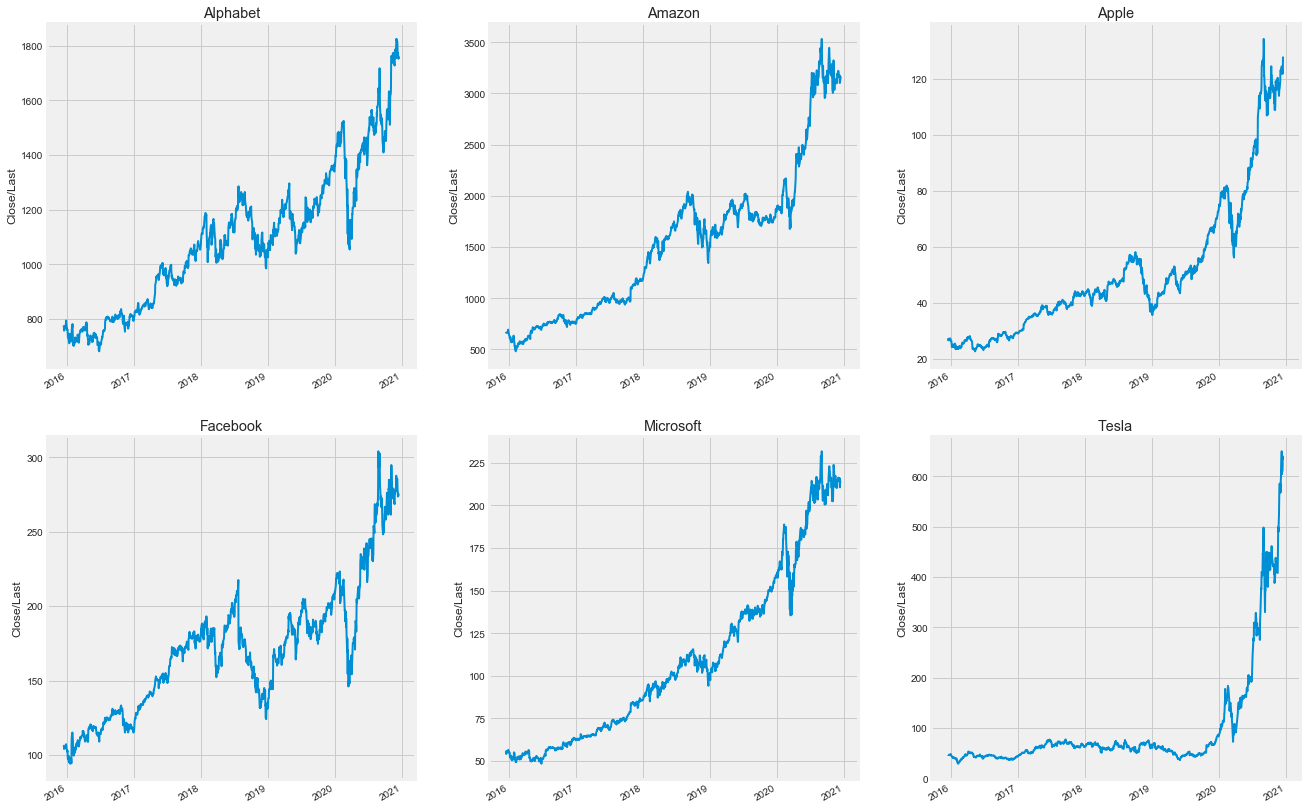

In [26]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_name, 1):
    plt.subplot(2, 3, i)
    df[df['Company'] == company]['Close/Last'].plot(linewidth=2.0)
    plt.ylabel('Close/Last')
    plt.xlabel(None)
    plt.title(f"{company_name[i - 1]}")

\- Trực quan kết quả bằng biểu đồ cột:

In [11]:
#df_1: Series đã xử lý
df_1 =  percent_family_edu(df_s.copy())

#Trực quan kết quả
sns.set(rc={'figure.figsize':(12,8)})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('% gia đình có con đạt A', fontsize='large')
ax.set_xlabel('Trình độ học vấn bố và mẹ', fontsize='large')
ax.bar(df_1.index, df_1.values, fill='black', color="#2ecc71", edgecolor=['black'])
df_1

NameError: name 'percent_family_edu' is not defined

**Kết luận:** Dựa vào biểu đồ trên, ta thấy biểu đồ có xu hướng tăng dần qua các mốc học vấn của cha mẹ, có thể nói cha mẹ càng có học vấn cao thì con của họ càng giỏi. Kết quả này thu được có thể do gen di truyền từ bố mẹ và môi trường học tập mà con cái nhận được sự quan tâm, chỉ bảo từ gia đình. 

---

---

- **<font color=red> 2. Có phải hầu hết học sinh đến từ thành thị? Vậy học sinh thành thị có học tốt hơn học sinh nông thôn hay không? </font>**

Để kiểm chứng, đầu tiên ta đưa ra dẫn chứng về số học sinh ở thành thị và số học sinh ở nông thôn:

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
c_2 = sns.countplot(df_s['address'])
c_2.axes.set_title('Học sinh thành thị và nông thôn', fontsize = 24)
c_2.set_xlabel('Nơi ở', fontsize = 20)
c_2.set_ylabel('Tổng số', fontsize = 20)
plt.show()

\- Lấy ra cột điểm trung bình của các học sinh đến từ thành thị (df_u) và nông thôn (df_r)

In [ ]:
df_u = df_s.loc[df_s['address'] == 'U', 'G_avg']
mean_u = df_u.mean()
df_r = df_s.loc[df_s['address'] == 'R', 'G_avg']
mean_r = df_r.median()

print("Mean Urban = {}, Mean Rural = {}".format(mean_u, mean_r))

\- Trực quan kết quả bằng biểu đồ:

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.kdeplot(df_u, label='Urban', shade = True)
sns.kdeplot(df_r, label='Rural', shade = True)

plt.axvline(mean_u, color='r', linestyle='-')
plt.axvline(mean_r, color='g', linestyle='-')

plt.legend({'Urban':df_u,'Rural': df_r ,'Mean Urban':mean_u,'Mean Rural':mean_r})
plt.title('Điểm G3 học sinh thành thị - nông thôn', fontsize = 20)
plt.xlabel('Điểm', fontsize = 20);
plt.ylabel('Tỉ lệ', fontsize = 20)
plt.show()

**Kết luận:** Nhìn vào biểu đồ, ta thấy học lực giữa thành thị và nông thôn có sự chênh lệch. Học sinh thành thị nhỉnh hơn từ mức điểm B trở lên ($>10$), thể hiện rõ ở mức điểm 15, và số điểm dưới 10 chiếm tỉ lệ thấp hơn (đường xanh nằm dưới đường cam). Nếu nhìn vào 2 vạch chỉ mức điểm trung bình thì luận điểm trên lại càng được cũng cố. Vì điều kiện học tập ở mỗi nơi là khác nhau nên chênh lệch là khó tránh khỏi, do đó, chính quyền cần chú trọng hơn vào giáo dục ở nông thôn, những vùng kém phát triển. 

---

- **<font color=red> 3.Yêu đương làm ảnh hưởng đến kết quả học tập? </font>**

Để giải quyết câu hỏi này, ta cần quan tâm đến 3 cột thuộc tính **romantic** và **G3** -  kết quả học kỳ 3. 

In [ ]:
#Lấy series của cột romatic
df_3 = df_s['romantic'].copy().value_counts()

#Trực quan %
plt.figure(figsize=(12,8))
plt.axis('equal');
# colors = ['#008fd5', '#fc4f30']
colors = ['#008fd5', '#fc6f30']
plt.pie(df_3, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
        explode = (0, 0.1), autopct='%1.f%%',shadow=True);
plt.legend(loc='best', labels=df_3.index, fontsize='medium')
plt.show()

\- Tạm gọi nhóm các học sinh có quan hệ yêu đương là nhóm cam và nhóm các học sinh còn lại là nhóm xanh. Ta thấy có tới 1/3 số học sinh đang trong quan hệ yêu đương (nhóm màu cam)... Vậy cần so sánh mức điểm của nhóm này với các học sinh còn lại xem sao: 

In [ ]:
b = sns.swarmplot(x=df_s['romantic'],y=df_s['G3'])
b.axes.set_title('Tình trạng yêu đương và kết quả học tập', fontsize = 22)
b.set_xlabel('Tình trạng quan hệ', fontsize = 20)
b.set_ylabel('Điểm học tập', fontsize = 20)
plt.show()

**Kết luận:** Qua biểu đồ trên, ta thấy số học sinh đạt điểm cao ở nhóm cam khá ít. So về tỉ lệ đối với nhóm xanh thì thực sự rất thấp. Đặc biệt số điểm 0 của nhóm cam lại nhiều hơn nhóm xanh, tình trạng này thực sự rất tệ không chỉ với riêng nhóm cam mà còn cả với nhóm xanh. 

Do đó, yêu đương có thể ảnh hưởng tiêu cực đến việc học. Nhà trường cần kiểm soát tốt hơn về vấn đề này để học sinh không sao nhãng việc học.

---

- **<font color=red> 4. Tình trạng uống rượu bia theo lứa tuổi của học sinh ở Bồ Đào Nha? </font>**

Để giải quyết câu hỏi này, ta cần quan tâm đến 2 cột thuộc tính **Dalc** và **age**. 

\- Đầu tiên ta rút ra số lượng của các nhãn rời rạc trong cột **Dalc** dưới dạng Series. 

In [ ]:
#Lấy series của cột Dalc
se_dalc = df_s['Dalc'].copy().value_counts()
print("Thống kê số lượng của các nhãn rời rạc trong cột Dalc\n")
se_dalc

\- Sau đó trực quan bằng Pie Chart như sau:

In [ ]:
#Trực quan %
plt.figure(figsize=(12,8))
plt.axis('equal')

colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]
plt.pie(se_dalc, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
        explode = (0, 0.1,0.1,0.1,0.1), autopct='%1.f%%',shadow=True);
plt.legend(loc='best', labels=se_dalc.index, fontsize='medium')
plt.show()

\- Qua số liệu của cột **Dalc** thì mức dộ sử dụng rượu/bia được đánh giá theo thang từ 1 - *rất ít*, đến 5 - *rất nhiều*. Do đó ta đặt mức lớn hơn 1 (**Dalc** $\ge$ 2) làm mốc đánh giá là có sử dụng rượu/bia. Tạo bảng dữ liệu gồm 2 cột **age** và **Dalc** vừa lọc ra ở trên.


In [ ]:
df_4 = df_s[df_s['Dalc'] > 1]
df_4 = df_4[['age','Dalc']]
df_4.head()

\-  Tiếp đến, ta cần đưa ra số liệu thống kê về số học sinh sử dụng rượu/bia theo độ tuổi bằng cách xây dựng hàm <font color=blue> count_age_acl </font>. Với đầu vào là DataFrame đang xét (df_4) và Series của cột **age**. 

In [ ]:
def count_age_acl(dataframe, series):
    #Sắp xếp lại giá trị index của series theo chiều tăng của tuổi.
    series.sort_index(inplace = True)
    
    #Danh sách các số đếm của từng độ tuổi.
    acl_list = []
    num = 0
    for i in series.index:
        num = len(dataframe[dataframe['age'] == i])
        acl_list.append(num)
    series.replace(series.values, acl_list, inplace = True)
    return series

\- Kết quả trả về một Series có Index là độ tuổi và Value là số học sinh sử dụng rượu/bia.

In [ ]:
se_age = df_s.copy()['age'].value_counts()
se_age = count_age_acl(df_4, se_age)
se_age

\- Trực quan dưới dạng biểu đồ đường:

In [ ]:
# plt.figure(figsize=(10,7))
title = "Số học sinh sử dụng rượu/bia theo độ tuổi"
se_age.plot(kind = 'line', marker='o', title = title, grid = True, legend = True, colormap = 'Reds_r')
plt.ylabel('Số học sinh');

**Kết luận:** Nhìn vào biểu đồ, ta thấy mức độ sử dụng rượu bia ở các lứa tuổi khá chênh nhau. Lứa tuổi từ 15-18 sử dụng rượu bia rất nhiều, nhất là những học sinh 17 tuổi. Theo như mình tìm hiểu thì độ tuổi được phép uống rượu/bia ở Bồ Đào Nha là 16 đối với loại nhẹ và 18 đối với loại rượu nặng (tham khảo [ở đây](https://www.apyn.org/triangle-portugal#:~:text=There%20are%20now%20two%20legal,of%20alcoholic%20beverages%20(spirits).) \), nên thống kê trên là đáng báo động vì ở độ tuổi 15, các bạn đã tiêu thụ rượu khá nhiều... Mức tiêu thụ này giảm dần từ lứa tuổi 19 trở đi, dù độ tuổi này việc sử dụng chất có cồn đã được hợp pháp hóa.

---

- **<font color=red> 2. Yếu tố tác động tích cực và tiêu cực đến kết quả học tập? </font>**

Sử dụng mô hình học máy (cụ thể là Linear Regression) rút ra những trọng số mà ta cần, dựa vào đó để đánh giá các tác động của thuộc tính đến kết quả bài kiểm tra cuối kỳ G3.

<ins> *Chú thích: </ins> Phương pháp Linear Regression (Hồi quy tuyến tính) áp dụng cho loại mô hình tuyến tính với các trọng
số w = (w1,…, wp) và các mục tiêu được dự đoán bằng phép gần đúng tuyến tính.  

<ins> Ví dụ: </ins>: Bạn có mục tập thuộc tính bất kỳ X = [$a_1, a_2, a_3$] và tập kết quả tương tứng y = [$b_1$]. Nhiệm vụ của Linear Regression là tìm các trọng số  $w$ = ($w_0, w_1, w_2, w_3$) sao cho:

$$ w_0 + w_1a_1 + w_2a_2 + w_3a_3 \approx b_1$$

\- Lọc ra các cột chứa kiểu dữ liệu int:

In [ ]:
df_5 = df_s.copy().select_dtypes('int64')
df_5.head()

\- Chọn những cột thuộc tính mà ta quan tâm: 

In [ ]:
df_5 = df_5[['famrel', 'studytime', 'failures', 'absences', 'G1', 'G2','G3']]
# sklearn needs numpy array's as inputs
X = np.array(df_5.drop('G3', axis=1))
y = np.array(df_5['G3'])

df_5.head()

\- Phân tách các tập dữ liệu huấn luyện (X_train, y_train) và tập dữ liệu test (X_test, y_test) từ tập X, y phía trên.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

\- Bắt đầu quá trình huấn luyện: 

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)

In [ ]:
#Xuất thông tin về độ hiệu quả của thuật toán:
print("Độ chính xác: ", linear.score(X_test, y_test))
coeff = linear.coef_

#Xuất kết giá trị các trọng số:
for i in range(len(coeff)):
    print(df_5.columns[i], ': ', coeff[i])

**Kết luận:** Ta đưa ra nhận xét dựa vào hững thuộc tính cho ra kết quả dương (tích cực) và âm (tiêu cực):

Dễ thấy điểm thi ở đợt kiểm tra cuối (**G3**) chịu tác động tích cực từ mức độ hạnh phúc của gia đình (**famrel**), kết quả thi đợt 1 (**G1**) và kết quả thi đợt 2 (**G3**). Nghĩa là nếu những yếu tố này càng cao thì có thể kết quả thi **G3** càng tốt. Ví dụ 1 học sinh có thể cố gắng hơn nếu điểm **G1** và **G2** của học sinh đó chưa đạt được như nguyện vọng. 

Yếu tố tiêu cực **failures** (số lỗi vi phạm) là điều dễ hiểu vì chỉ số này ít khi xuất hiện ở 1 học sinh học lực tốt. Nhưng điều lạ ở đây là thuộc tính **studytime** (thời gian học tập) lại là tiêu cực... kết quả này đi ngược với suy nghĩ "học càng nhiều thì càng tốt", nó đúng hơn với câu "học quá nhiều chưa hẳn là tốt".

---

# V/ Nhìn lại quá trình làm đồ án:


Qua quá trình làm đồ án, mình rút ra một số ý:

> **Thuận lợi**:
- Dữ liệu sạch và không cần tiền xử lý nhiều.
- Kích thước dữ liệu nhỏ nên việc chạy code khá nhanh.
- Dữ liệu đa dạng thuộc tính nên có nhiều lựa chọn cách triển khai.

> **Khó khăn**:
- Do dữ liệu có đến 33 cột thuộc tính nên chưa khai thác hết được.
- Kích thước dữ liệu nhỏ nên chưa đảm bảo tính chính xác khi áp dụng học máy để dự đoán.

Từ việc phân tích tập dữ liệu trên, mình có thể đánh giá các yếu tố ảnh hưởng đến kết quả học tập cảu một học sinh. Từ đó rút ra kinh nghiệm cho bản thân để tránh những yếu tố tiêu cực và phát huy những mặt tích cực, cải thiện thành tích. Giúp mình nhận thấy các tác động từ gia đình, xã hội cũng một phần quyết định đến kết quả học tập. 

Nếu có nhiều thời gian hơn, mình sẽ tận dụng triệt để các thuộc tính còn lại nhằm cũng cố những suy luận phía trên. 

# VI/ Tài liệu tham khảo:

Các bài đóng góp trên : [Notebooks](https://www.kaggle.com/dipam7/student-grade-prediction/notebooks)